# Data Exploration Noetbook

In this notebook the Starbucks Capstone Challenge dataset is examined. We try to obtain how the dataset is structured, which features seem to be relevant and what are the basic distribution properties of the data. We also try to find outlier data and decide how to deal with them during feature engineering.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from source import exploration_helpers

In [4]:
reload(exploration_helpers)

<module 'source.exploration_helpers' from '/home/ferenc/Documents/Udacity/Machine_Learning_Engineer/Starbucks_Capstone_Project/source/exploration_helpers.py'>

### Reading in the data files:

In [5]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

---
## Examining the portfolio

In [6]:
# converting the duration into hours:
portfolio.duration = portfolio.duration.apply(lambda x: x * 24)

In [7]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


---
## Examining the Profile data

In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
# counting the data and the invalid data:
num_people = len(profile.index)
num_missing_age = (profile['age'] == 118).sum()
num_missing_gender = profile['gender'].isna().sum()
num_missing_income = profile['income'].isna().sum()
num_missing_gender_and_income = (profile['gender'].isna() & profile['income'].isna()).sum()
num_missing_gender_and_age = (profile['gender'].isna() & (profile['age'] == 118)).sum()

# printing the results:
print('number of people: {}'.format(num_people))
print('number of missing age: {}'.format(num_missing_age))
print('number of missing gender: {}'.format(num_missing_gender))
print('number of missing income: {}'.format(num_missing_income))
print('number of missing gender and income: {}'.format(num_missing_gender_and_income))
print('number of missing gender and age: {}'.format(num_missing_gender_and_age))

number of people: 17000
number of missing age: 2175
number of missing gender: 2175
number of missing income: 2175
number of missing gender and income: 2175
number of missing gender and age: 2175


In [10]:
# splitting the profile data:
complete_indices = profile.index[profile['gender'].notna()]
missing_indices = profile.index[profile['gender'].isna()]

profile_complete = profile.iloc[complete_indices].copy()
profile_missing = profile.iloc[missing_indices].copy()

### Membership length

Next we create a new feature called "membership_length" and replace the "became_member_on" feature with it. As only the relative lengths of the membership lengths are going to be interesting after normalizing the data, it does not matter for which future date we calculate the length. For The sake of simplicity we are going to calculate it from the latest membership start.

In [11]:
# calculating membership length and removing the became_member_on feature from the df:
profile_complete = exploration_helpers.get_membership_length(profile_complete)

profile_complete.head()

,gender,age,id,income,membership_length
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,91
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,167
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257


### Plotting the profile data
In the following we are going to plot some distributions of the complete data to check how well it is distributed.

First we are going to check the male-female distribution.

In [12]:
# counting the female and male datapoints:
F_count = (profile_complete['gender'] == 'M').sum()
M_count = (profile_complete['gender'] == 'F').sum()
O_count = (profile_complete['gender'] == 'O').sum()

print('Number of females: {}'.format(F_count))
print('Number of males: {}'.format(M_count))
print('Number of people with other gender: {}'.format(O_count))

Number of females: 8484
Number of males: 6129
Number of people with other gender: 212


The number of male and female datapoints is quite well distributed, so no care has to be taken on compensating it in any direction.

The number of people who classify themselves into other genders is however very small. These people are decided to be kept in the dataset but we assume that the predictions on them will not be very accurate.

The people with no given profile data will also be kept in the dataset with a fourt gender 'U'. This will define the separate cathegory for them. The age and income data will be filled up with the respective mean values.

Next we plot the distribution of age, income and membership length for both genders:

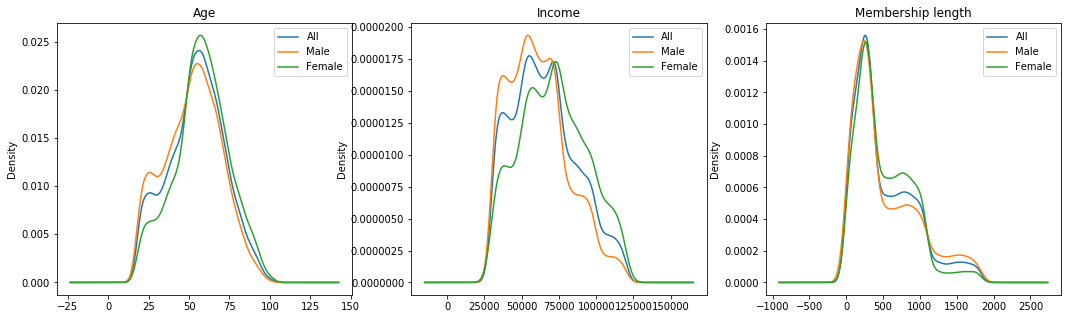

In [13]:
fig, axis = plt.subplots(figsize=(18,5), nrows=1, ncols=3)

for i, column in enumerate(['age', 'income', 'membership_length']):
    df_all = profile_complete[column]
    df_male = profile_complete[column][profile_complete.gender == 'M']
    df_female = profile_complete[column][profile_complete.gender == 'F']
    # concatenating the dataframes:
    df_to_plot = pd.concat([df_all, df_male, df_female], ignore_index=True, axis=1)
    #renaming columns:
    columns = ['All', 'Male', 'Female']
    df_to_plot.columns = columns
    
    # plotting:
    df_to_plot.plot.density(ax=axis[i])
    
axis[0].set_title('Age')
axis[1].set_title('Income')
axis[2].set_title('Membership length')


plt.show()

From the above plots we examine the following propoerties:
* The age distribution is relative nice. It has got a small peak around 25 years, but we assume that it will not pose a huge probelm during training.
* The income is not very well distributed however possiby will be sufficient for training. There are some local peaks. Also there are some significant differences between the male and female distributions. The male costumers tend to have lower income than the female costumers.
* The membership length distribution is also not well distributed. It has a huge peak between 0 and 500. Other than that, there tend to be some intervals where the distribution is almost constant. 

From this we conclude that possibly some transformation on the membership length data is necessary.

---
## Transactional data

In [16]:
# visualizing some from the Transactional data:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
# extracting the transaction values:
transcript = exploration_helpers.extract_transcript_values(transcript)

transcript.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


First of all we count for each person, how many offers have they viewed, how many have they viewed and completed and how many have they completed without viewing it:

In [15]:
profile = exploration_helpers.get_offer_stats(transcript, profile, portfolio)

# printing some samples:
profile.loc[1:10]

0 out of 17000 is done
1000 out of 17000 is done
2000 out of 17000 is done
3000 out of 17000 is done
4000 out of 17000 is done
5000 out of 17000 is done
6000 out of 17000 is done
7000 out of 17000 is done
8000 out of 17000 is done
9000 out of 17000 is done
10000 out of 17000 is done
11000 out of 17000 is done
12000 out of 17000 is done
13000 out of 17000 is done
14000 out of 17000 is done
15000 out of 17000 is done
16000 out of 17000 is done


,gender,age,id,became_member_on,income,num_viewed,num_viewed_completed,num_not_viewed_completed
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0,0,1
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,4,2,1
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,3,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,3,2,0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN,5,0,0
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN,4,0,0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,6,5,0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN,3,0,1
10,None,118,c4863c7985cf408faee930f111475da3,20170824,NaN,3,1,0


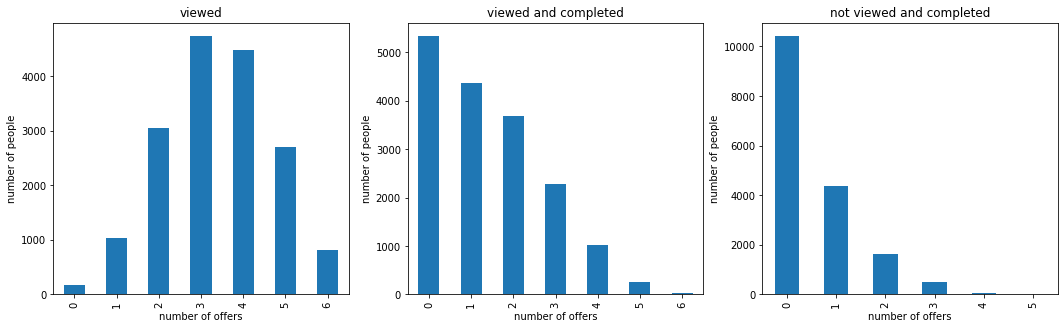

In [16]:
# plotting the distribution of the number of viewed, viewed and completed and not viewed but completed numbers:
fig, axis = plt.subplots(figsize=(18,5), nrows=1, ncols=3)

df_viewed = profile.num_viewed.value_counts().sort_index()
df_viewed.plot.bar(ax=axis[0])
axis[0].set_title('viewed')
axis[0].set_xlabel('number of offers')
axis[0].set_ylabel('number of people')

df_viewed_completed = profile.num_viewed_completed.value_counts().sort_index()
df_viewed_completed.plot.bar(ax=axis[1])
axis[1].set_title('viewed and completed')
axis[1].set_xlabel('number of offers')
axis[1].set_ylabel('number of people')

df_not_viewed_completed = profile.num_not_viewed_completed.value_counts().sort_index()
df_not_viewed_completed.plot.bar(ax=axis[2])
axis[2].set_title('not viewed and completed')
axis[2].set_xlabel('number of offers')
axis[2].set_ylabel('number of people')

plt.show()

### Offer type distribution

In the followings we are going to check the distribution among the offer types.

In [14]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

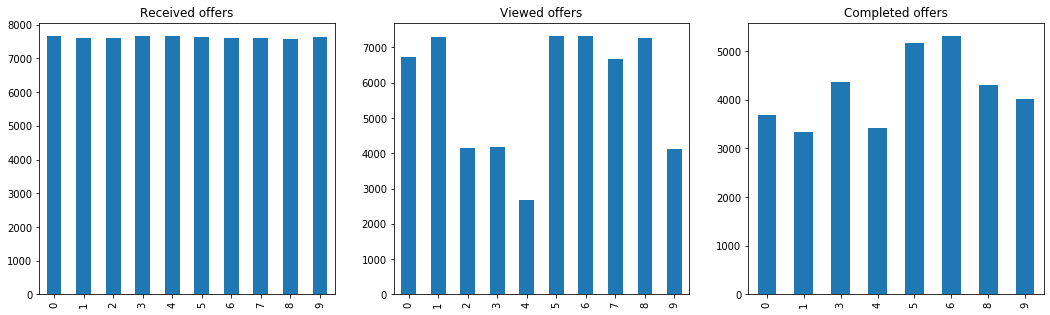

In [19]:
# dictionary to rename the index of the df where the different types of offers are count:
rename_dict = dict(zip(portfolio.id.values, portfolio.index))

received_offers_df = transcript[transcript.event == 'offer received']
received_types_count = received_offers_df.offer_id.value_counts()
received_types_count = received_types_count.rename(index=rename_dict).sort_index()

viewed_offers_df = transcript[transcript.event == 'offer viewed']
viewed_types_count = viewed_offers_df.offer_id.value_counts()
viewed_types_count = viewed_types_count.rename(index=rename_dict).sort_index()

completed_offers_df = transcript[transcript.event == 'offer completed']
completed_types_count = completed_offers_df.offer_id.value_counts()
completed_types_count = completed_types_count.rename(index=rename_dict).sort_index()

# plotting the distributions:
fig, axis = plt.subplots(figsize=(18,5), nrows=1, ncols=3)

received_types_count.plot.bar(ax=axis[0])
axis[0].set_title('Received offers')

viewed_types_count.plot.bar(ax=axis[1])
axis[1].set_title('Viewed offers')

completed_types_count.plot.bar(ax=axis[2])
axis[2].set_title('Completed offers')

plt.show()

From the plots above van can see the followings: 
* The amount of sent out promotions is almost the same from every type of advertisement.
* The amount of viewed promotions vaires stronger and by far the least people viewed the promotion with the highest difficulty and longest duration.
* The completion is also relatively homogeneous. (The offer types 2 and 7 correspond to the advertisements, which can not be completed, hence these are missing from the table.)

### Transactions

In the following the transactions are analyzed

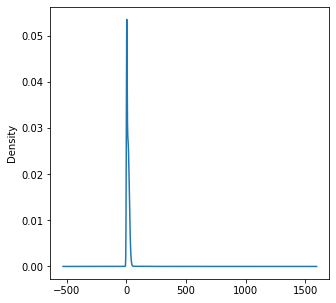

In [19]:
# plotting the transaction distribution:
fig = plt.figure(figsize=(5, 5))

transactions_df = transcript[transcript.event == 'transaction']
transactions_df.head()
transactions_df.amount.plot.density()

plt.show()

In [20]:
print('mean: {}'.format(transactions_df.amount.mean()))
print('max: {}'.format(transactions_df.amount.max()))

for limit in [20, 50, 80, 100]:
    num_bigger = (transactions_df.amount > limit).sum()
    print('number of transactions with amount higher than {} dollars: {}'.format(limit, num_bigger))

mean: 12.777356156398204
max: 1062.28
number of transactions with amount higher than 20 dollars: 28232
number of transactions with amount higher than 50 dollars: 706
number of transactions with amount higher than 80 dollars: 553
number of transactions with amount higher than 100 dollars: 478


From the above diagram we can see, that most of the data is in a normal range, but there are possibly some very few data points, which have unlikely high values. We will try to get rid of the people and all the datapoints which belong to them, because they are not representative for the group.

In [21]:
# calculating the cummulative money spent for each person:
if 'total_spent' not in profile.columns:
    profile.insert(loc=len(profile.columns), column='total_spent', value=np.zeros_like(profile.index))

for person in profile.id:
    person_mask = (transactions_df.person == person)
    transactions_of_person = transactions_df.amount[person_mask]
    
    profile.loc[(profile.id == person), 'total_spent'] = transactions_of_person.sum()

profile.head()

,gender,age,id,became_member_on,income,num_viewed,num_viewed_completed,num_not_viewed_completed,total_spent
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,5,2,0,20.40
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0,0,1,77.01
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2,0,0,14.30
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,4,2,1,159.27
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,3,0,0,4.65


### Some stats about the money spent per person:

In [22]:
print('mean: {}'.format(profile.total_spent.mean()))
print('max: {}'.format(profile.total_spent.max()))

for limit in [100, 200, 300, 500, 1000]:
    num_bigger = (profile.total_spent > limit).sum()
    print('number of people whoe spent more than {} dollars: {}'.format(limit, num_bigger))

num_zero = (profile.total_spent == 0).sum()
print('number of people who spent 0 dollars: {}'.format(num_zero))



mean: 104.43835117647058
max: 1608.69
number of people whoe spent more than 100 dollars: 6722
number of people whoe spent more than 200 dollars: 2349
number of people whoe spent more than 300 dollars: 738
number of people whoe spent more than 500 dollars: 272
number of people whoe spent more than 1000 dollars: 48
number of people who spent 0 dollars: 422


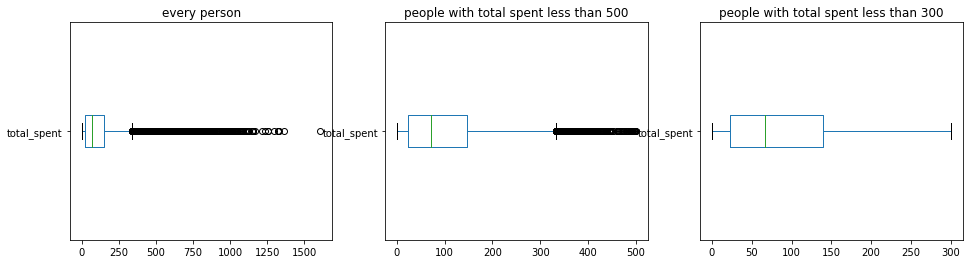

In [23]:
fig, axis = plt.subplots(figsize=(16,4), nrows=1, ncols=3)

profile.total_spent.plot.box(ax=axis[0], vert=False)
axis[0].set_title('every person')

mask1 = (profile.total_spent < 500) & (profile.total_spent != 0)
profile.total_spent[mask1].plot.box(ax=axis[1], vert=False)
axis[1].set_title('people with total spent less than 500')

mask2 = (profile.total_spent < 300) & (profile.total_spent != 0)
profile.total_spent[mask2].plot.box(ax=axis[2], vert=False)
axis[2].set_title('people with total spent less than 300')
plt.show()

Based on these figures the people who spent more the 300 dollar in total or did not spend anything are going to be dropped from the dataset, because they are not considered to be representative. This means a total of 1160 people to be dropped from the data. This is only 6.8% of the people and we assume that around the same amount of data will be lost from the transcript dataset.